# Homework 04: Building CNNs for Image Classification

## Due: Midnight on February 15 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects. 

There are 10 graded questions, worth 8 points each, with 5 points free if you complete all of the graded questions in the homework. 


## 1. Setup and Data Loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-18 09:55:55.724919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
!{sys.executable} -m pip install -U numpy pandas matplotlib seaborn scikit-learn tensorflow kagglehub pillow requests


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: https://repo.forge.lmig.com/api/pypi/python/simple
  Using cached https://repo.forge.lmig.com/api/pypi/python/packages/packages/2d/98/121996dcfb10a6087a05e54453e28e58694a7db62c5a5a29cee14c6e047b/numpy-2.0.2-cp39-cp39-macosx_14_0_x86_64.whl (6.9 MB)
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [3]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default 
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,                  
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),      
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  



In [5]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

100%|██████████| 346M/346M [00:54<00:00, 6.62MB/s] 

Extracting files...


In [6]:
# Reproducible load + preprocess for Intel Image Classification

# -------------------------
# Loader (deterministic)
# -------------------------
def load_data_from_directory(directory, img_size=(150, 150), class_names=None):
    """
    Loads images as float32 in [0,1] and integer labels.
    Sorting ensures deterministic order. If class_names is provided,
    that ordering defines label indices.
    Returns: X, y, class_names_used
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # Ensure only classes present in directory are used (robustness)
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        # Sort filenames so load order is reproducible
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            # Explicit interpolation for consistency
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img)  # float32
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = (np.array(X, dtype="float32") / 255.0)   # normalize to [0,1]
    y = np.array(y, dtype="int32")               # integer labels
    return X, y, class_names

def show_counts(name, y_arr):
    c = Counter(y_arr.tolist() if hasattr(y_arr, "tolist") else y_arr)
    print(f"{name} per-class counts:", dict(c))

# -------------------------
# Download & paths
# -------------------------
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

# -------------------------
# Load train (get class_names) & test using same mapping
# -------------------------
X_train_all, y_train_all, class_names = load_data_from_directory(train_dir, img_size=(150,150))
X_test,       y_test,   _            = load_data_from_directory(test_dir, img_size=(150,150), class_names=class_names)

num_classes = len(class_names)
print("class_names:", class_names)
print("X_train_all:", X_train_all.shape, "y_train_all:", y_train_all.shape)
print("X_test:     ", X_test.shape,      "y_test:     ", y_test.shape)

# -------------------------
# Stratified train/val split (reproducible)
# -------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.2,
    stratify=y_train_all,
    random_state=random_seed,
    shuffle=True
)

class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_train_all: (14034, 150, 150, 3) y_train_all: (14034,)
X_test:      (3000, 150, 150, 3) y_test:      (3000,)


### Examine The Dataset

In [7]:
print("X_train:",  X_train.shape,  "y_train:",  y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

X_train: (11227, 150, 150, 3) y_train: (11227,)
X_val: (2807, 150, 150, 3) y_val: (2807,)
train per-class counts: {0: 1753, 4: 1819, 2: 1923, 1: 1817, 5: 1906, 3: 2009}
val   per-class counts: {1: 454, 2: 481, 3: 503, 0: 438, 4: 455, 5: 476}
test  per-class counts: {0: 437, 1: 474, 2: 553, 3: 525, 4: 510, 5: 501}


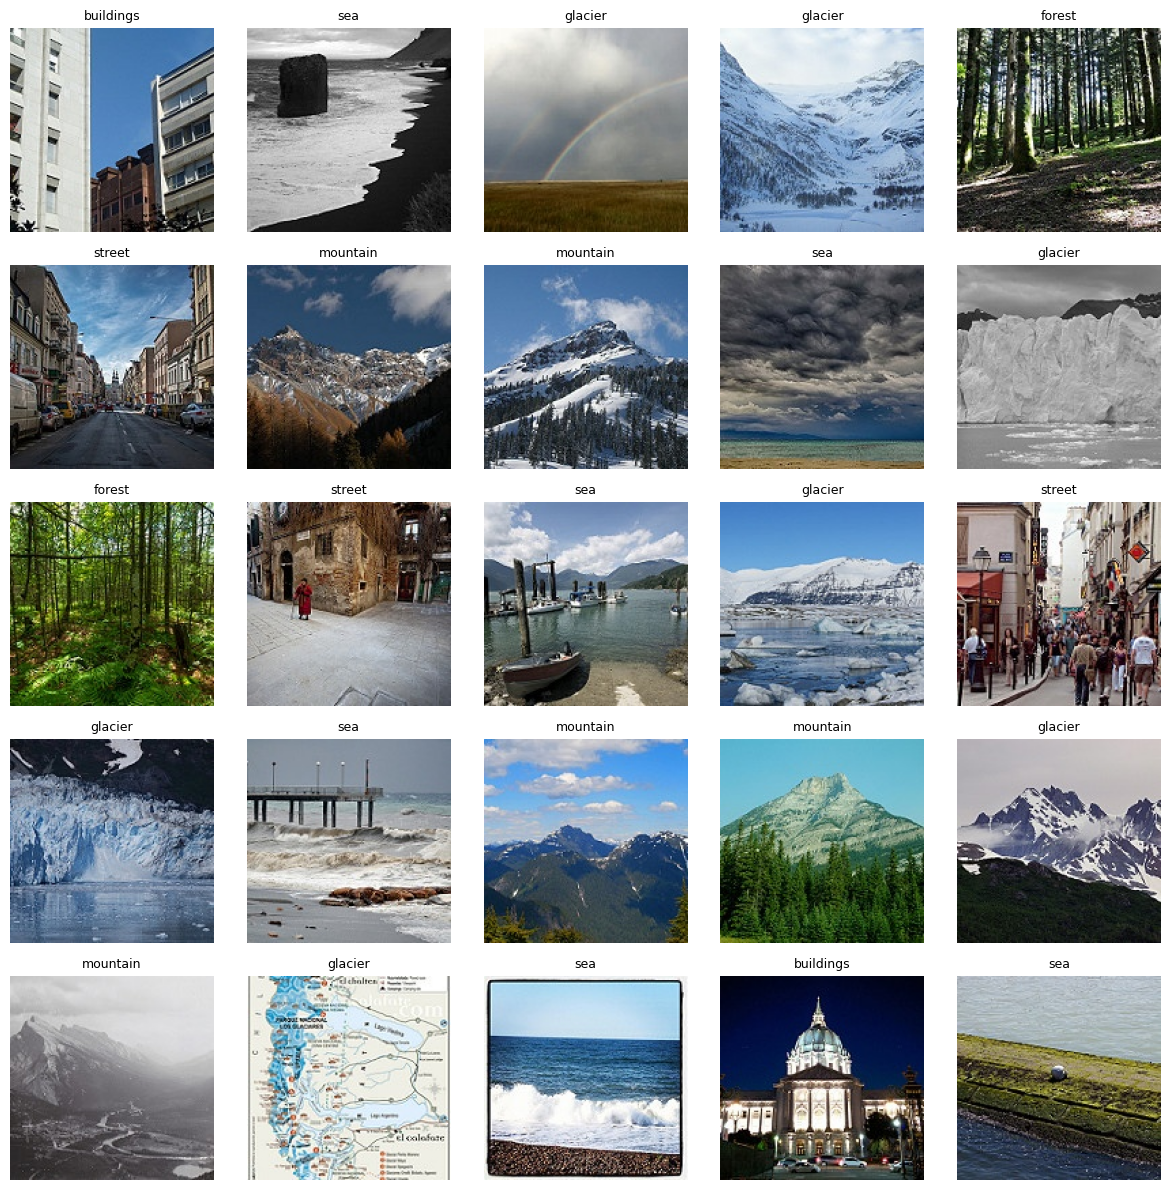

In [8]:
# Show a 5×5 grid of the first 25 training images
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    # X_train is already a NumPy array [0–1], so no .numpy() needed
    plt.imshow(X_train[i])
    # pick the class name from your class_names list
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!). 

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in. 


In [9]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),            
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title="Baseline Model")



Baseline Model



KeyboardInterrupt: 

## BUT: Every couple of iterations, it does this!

Remember that initializations are random, even if controlled by HeNormal, so you may have exploding/disappearing gradients....a


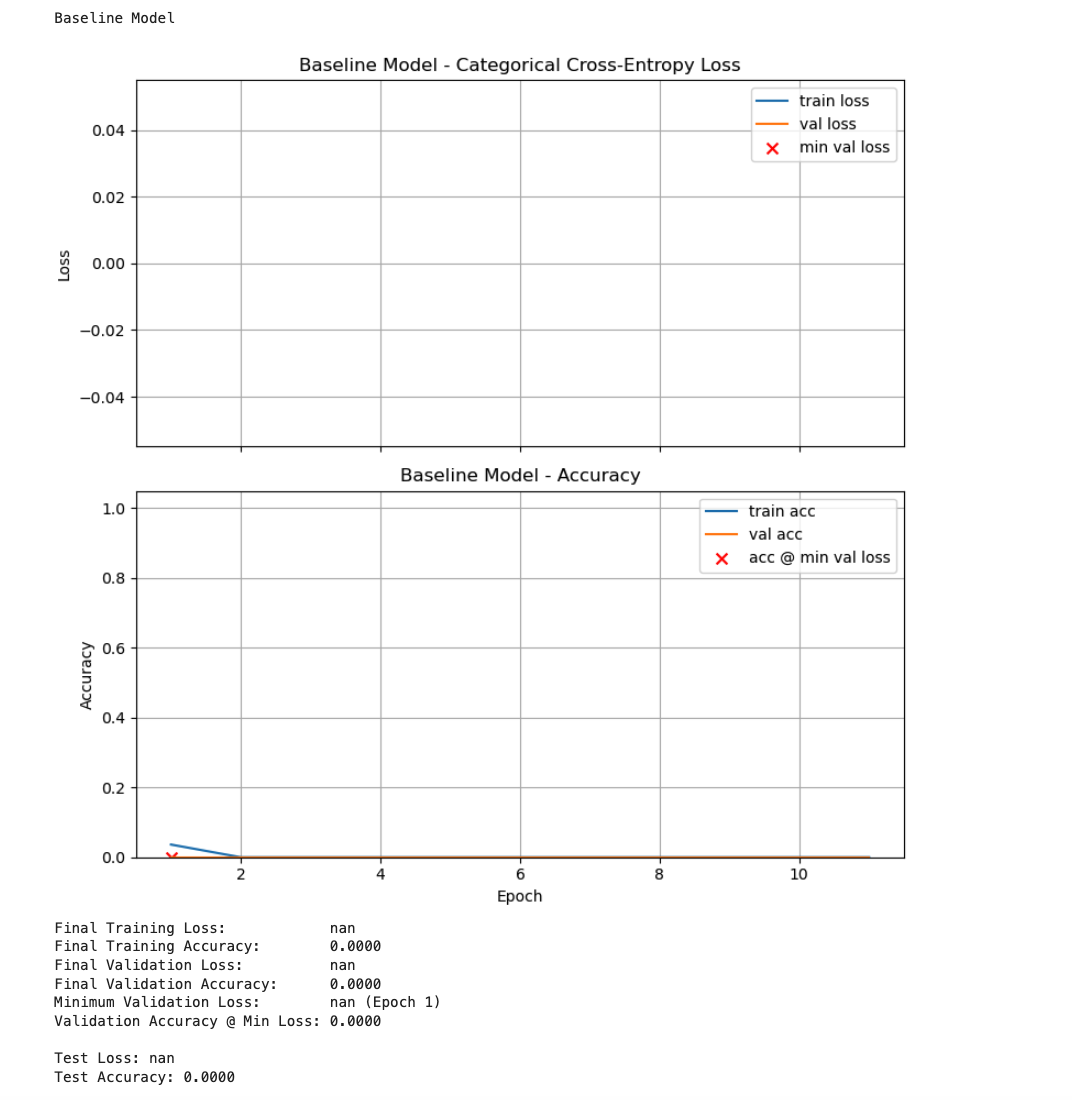

## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer. 
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5). 


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).

In [ ]:
# Your code here, add additional cells if you wish

he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation='relu', kernel_initializer=he, padding="same"),
    BatchNormalization(), 
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he), 
    
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title="Baseline Model")

In [ ]:
# =========================
# Problem 1 — Run 3 isolated tweaks WITHOUT changing your baseline cell.
# Keep your baseline cell exactly as-is, then run the cells below.
# =========================

import tensorflow as tf
from tensorflow.keras import models, initializers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# -------- TWEAK 1: Learning rate (compile + fit directly so lr definitely changes) --------
he = initializers.HeNormal()

model_tweak1_lr = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation='relu', kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_tweak1_lr.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_tweak1_lr = model_tweak1_lr.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

plot_history(hist_tweak1_lr)


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 220s 620ms/step - accuracy: 0.2339 - loss: 3.4032 - val_accuracy: 0.1792 - val_loss: 1.7912
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 198s 563ms/step - accuracy: 0.2102 - loss: 1.7385 - val_accuracy: 0.3644 - val_loss: 1.5555
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 203s 579ms/step - accuracy: 0.2590 - loss: 1.6498 - val_accuracy: 0.3502 - val_loss: 1.5051
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 203s 579ms/step - accuracy: 0.2609 - loss: 1.6395 - val_accuracy: 0.1792 - val_loss: 1.7997
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 219s 623ms/step - accuracy: 0.1748 - loss: 1.7987 - val_accuracy: 0.1792 - val_loss: 1.7951
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 1151s 3s/step - accuracy: 0.1748 - loss: 1.7947 - val_accuracy: 0.1792 - val_loss: 1.7928
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 198s 565ms/step - accuracy: 0.1748 - loss: 1.7927 - val_accuracy: 0.1792 - val_loss: 1.7917
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 201s 572ms/step - accuracy: 0.1748 - l

In [ ]:
# -------- TWEAK 2: Wider Conv2D layers (32/64 -> 64/128) --------
he = initializers.HeNormal()

model_tweak2_wideconv = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(64, (3,3), activation='relu', kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_tweak2_wideconv.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_tweak2_wideconv = model_tweak2_wideconv.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

plot_history(hist_tweak2_wideconv)


In [ ]:
# -------- TWEAK 3: Dropout rate (0.5 -> 0.3) --------
he = initializers.HeNormal()

model_tweak3_dropout = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation='relu', kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model_tweak3_dropout.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_tweak3_dropout = model_tweak3_dropout.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

plot_history(hist_tweak3_dropout)


### Graded Questions

In [ ]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = ...             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = Ellipsis


In [ ]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a. 

a1b = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.0000


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence. 

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer. 
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design. 
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.



In [ ]:
# Your code here, add additional cells if you wish



### Graded Questions

In [ ]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = ...             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 


a2a = Ellipsis


In [ ]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem) 

a2b = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.0000


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video, 
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique). 

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block. 

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design. 
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.



In [ ]:
# Your code here, add additional cells if you wish



### Graded Questions

In [ ]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = ...             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 


a3a = Ellipsis


In [ ]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem) 

a3b = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.0000


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!). 
* Answer the graded questions.



In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

### Graded Questions

In [ ]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.0             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.2f}') 

a4a = 0.00


In [ ]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem) 

a4b = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.0000


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see [Explanation of VGG-16](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/) :
        

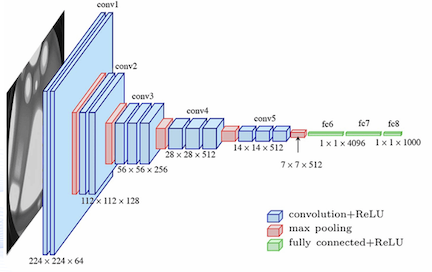


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss** 
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect. 



In [ ]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16,lr_schedule=1e-3,title="VGG-style Large")


### Graded Questions

In [ ]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 0.0             # Replace with your best learning rate

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.8f}') 

a5a = 0.00000000


In [ ]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem) 

a5b = 0.0              # Replace 0.0 with your answer           

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.0000


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [ ]:
print_results()

Baseline Model                          	0.0000	1


    VGG-style Large -- lr: 0.0001           	0.8700	18
    Model with ReduceLROnPlateau            	0.8636	227
    VGG-style Large -- lr: 0.0003           	0.8400	23
    VGG-style Large -- lr: 1e-05            	0.8301	60
    VGG-style Large -- lr: 3e-05            	0.8269	26
    Baseline model using BatchNormalization -- Tweak 2 -- 64 -> 128	0.8140	33
    Baseline Plus -- Tweaks 5 & 6 -- Do: 0.3	0.8030	50
    Baseline model using BatchNormalization -- Tweak 3 -- 32 -> 64 -> 128	0.8019	26
    Baseline model using BatchNormalization -- Tweak 4 -- Dense 128	0.7976	24
    Baseline model using BatchNormalization 	0.7941	7
    Baseline Plus -- Tweak 3 -- 32 -> 64 -> 128	0.7912	20
    Baseline Plus -- Tweak 6 -- Do: 0.3     	0.7745	36
    Baseline Plus -- Tweak 2 -- 64 -> 128   	0.7645	25
    Baseline Plus -- Tweak 5 -- L2: 1e-4    	0.7570	27
    Model using GAP                         	0.7553	10
    Baseline Plus -- Two Tweaks! -- L2: 1e-4 Do: 0.3	0.7506	19
    VGG-style Large -- lr: 0.001            	0.6865	5
    Baseline Plus -- Tweak 4 -- Dense 128   	0.5999	1
    Baseline Plus -- Tweak 1 -- lr: 1e-4    	0.4817	3
    Baseline model using BatchNormalization -- Tweak 1 lr: 0.0001 	0.3691	1
    VGG-style Large -- lr: 0.01             	0.1792	95
    VGG-style Large -- lr: 0.003            	0.1792	195
    Baseline Model                          	0.0000	1